In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import gc

from parameters_dict import physics_parameters
from exp_analysis_class import exp_analysis
from exp_analysis import gamma_heavy, gamma_heavy_integrated

In [3]:
case = 'heavy'
save_folder = ('../fig/control_checks/comparison_with_truth/' + case + '/')
!mkdir -p $save_folder

In [4]:
physics_parameters[case]

{'m4_limits': (0.005, 1),
 'mz_limits': (0.005, 10),
 'm4_scan': [0.01, 0.1, 0.5],
 'mz_scan': [0.01, 0.1, 1, 5],
 'alpha_dark': 0.4,
 'Umu4': 2.2e-07,
 'espilon2': 0.00046,
 'alpha_em': 0.0072992700729927005,
 'span_2d': 9.945025,
 'Vmu4_alpha_epsilon2': 2.9547445255474454e-13}

In [5]:
base_dir = '../data/nd280_nu/3plus1/scan/heavy_mediator/'

m4_range = physics_parameters['heavy']['m4_limits']
mz_range = [1, 2]
material = 'oxygen'

integral = {}

for fname in os.listdir(base_dir):
    if '.pckl' not in fname:
        continue
    print(fname)
    aux_exp_analysis = exp_analysis(case)
    aux_exp_analysis.load_df_base(filename=base_dir+fname)
    total_mask = aux_exp_analysis.df_base[material, ''] &\
                (aux_exp_analysis.df_base['m4', ''].values > m4_range[0]) &\
                (aux_exp_analysis.df_base['m4', ''].values < m4_range[1]) &\
                (aux_exp_analysis.df_base['mzprime', ''].values > mz_range[0]) &\
                (aux_exp_analysis.df_base['mzprime', ''].values < mz_range[1])
    corrected_weights = aux_exp_analysis.df_base['weight_decay', ''].values/aux_exp_analysis.df_base['mzprime', ''].values**4
    integral[aux_exp_analysis.df_base['mzprime', ''].values.max().round()] = corrected_weights[total_mask].sum()
    gc.collect()

0.01_m4_0.8_0.1_mzprime_5_nevt_1000.pckl
0.1_m4_0.5_0.01_mzprime_0.05_nevt_100000.0.pckl
0.01_m4_0.8_0.1_mzprime_5_nevt_100000.pckl
0.01_m4_0.8_0.1_mzprime_5_nevt_10000.pckl


In [6]:
integral

{5.0: 7.08162597543664e-23, 0.0: 0.0}

In [7]:
def area(m4_s, mz_s):
    return (mz_s[1] - mz_s[0] + mz_s[1] - m4_s[1]) * (m4_s[1] - m4_s[0]) / 2    

In [8]:
not_corrected = {}
corrected = {}
for mz_max, intg in integral.items():
    not_corrected[mz_max] = intg
    aux_area = area(m4_range, [physics_parameters['heavy']['m4_limits'][0], mz_max])
    corrected[mz_max] = intg * aux_area
    print(mz_max, aux_area)

5.0 4.4750125
0.0 -0.4999874999999999


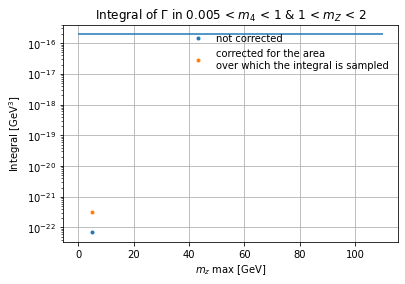

In [9]:
plt.plot(not_corrected.keys(), not_corrected.values(), '.', label='not corrected')
plt.plot(corrected.keys(), corrected.values(), '.', label='corrected for the area\nover which the integral is sampled')
plt.hlines(gamma_heavy_integrated(m4_range, mz_range, physics_parameters['heavy']['Vmu4_alpha_epsilon2']), 0, 110)
# plt.ylim(1e-18, 2e-14)
plt.yscale('log')
plt.legend(frameon=False)
plt.title(f'Integral of $\Gamma$ in {m4_range[0]} < $m_{{4}}$ < {m4_range[1]} & {mz_range[0]} < $m_{{Z}}$ < {mz_range[1]}')
plt.ylabel(r'Integral [GeV$^3$]')
plt.xlabel(r'$m_z$ max [GeV]')
plt.grid()